Grover's Algorithm Implementation and Testing
Test Case 1: 2-qubit Grover's Algorithm
Searching for state |11⟩ (binary: 11, decimal: 3)
Optimal iterations: 1
Success probability: 1.000
Target found in 1024/1024 measurements
Measurement results: {'11': 1024}

Test Case 2: 3-qubit Grover's Algorithm
Searching for states |101⟩ and |110⟩ (decimal: 5, 6)
Optimal iterations: 1
Success probability: 0.482
Targets found in 494/1024 measurements
Measurement results: {'011': 530, '101': 494}
Grover's Algorithm Implementation and Testing

Test Case 3: Iteration Analysis
Analyzing success probability vs number of iterations
Iterations: 1, Success probability: 0.000
Iterations: 2, Success probability: 0.233
Iterations: 3, Success probability: 0.236
Iterations: 4, Success probability: 0.000
Iterations: 5, Success probability: 0.271
All test cases completed!
Circuit depth (Test Case 1): 4
Circuit gates (Test Case 1): OrderedDict({'h': 2, 'barrier': 2, 'measure': 2, 'Oracle': 1, 'Diffuser': 1})


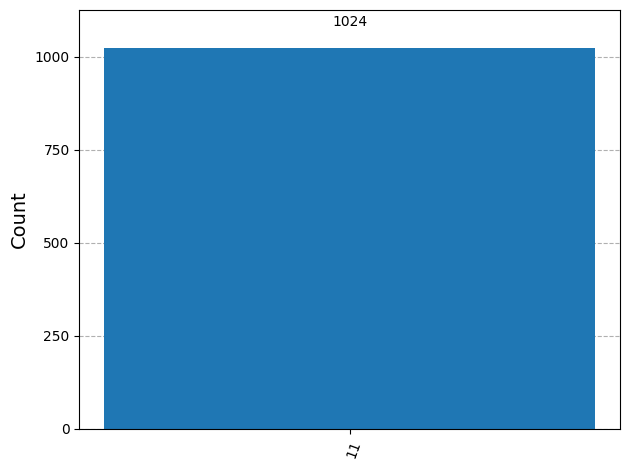

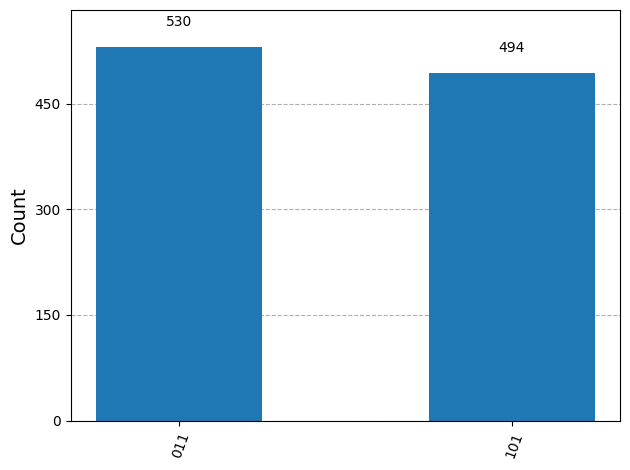

In [ ]:
%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

class GroversAlgorithm:
    def __init__(self, n_qubits, target_states):
        """
        Initialize Grover's Algorithm
        
        Args:
            n_qubits (int): Number of qubits
            target_states (list): List of target states to search for
        """
        self.n_qubits = n_qubits
        self.target_states = target_states
        self.N = 2**n_qubits  # Total number of states
        self.M = len(target_states)  # Number of target states
        
        # Optimal iterations formula: π/4 * sqrt(N/M) - 1/2
        if self.M == 1:
            self.optimal_iterations = int(np.pi/4 * np.sqrt(self.N) - 0.5)
        else:
            self.optimal_iterations = int(np.pi/4 * np.sqrt(self.N/self.M) - 0.5)
        
        self.optimal_iterations = max(1, self.optimal_iterations)
        
    def create_oracle(self):
        """
        Create oracle that flips the phase of target states
        Oracle marks the target states by applying a phase flip
        """
        oracle = QuantumCircuit(self.n_qubits, name='Oracle')
        
        # For each target state, create phase flip
        for target in self.target_states:
            # Convert target to binary and apply X gates for 0s
            binary_target = format(target, f'0{self.n_qubits}b')
            
            # Apply X gates to qubits that should be 0 in target state
            for i, bit in enumerate(binary_target):
                if bit == '0':
                    oracle.x(i)
            
            # Multi-controlled Z gate (phase flip)
            if self.n_qubits == 1:
                oracle.z(0)
            elif self.n_qubits == 2:
                oracle.cz(0, 1)
            elif self.n_qubits == 3:
                oracle.ccz(0, 1, 2)
            else:
                # For more qubits, use multi-controlled Z with ancilla
                oracle.h(self.n_qubits - 1)
                oracle.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
                oracle.h(self.n_qubits - 1)
            
            # Undo X gates
            for i, bit in enumerate(binary_target):
                if bit == '0':
                    oracle.x(i)
        
        return oracle
    
    def create_diffuser(self):
        """
        Create diffusion operator (amplitude amplification about average)
        Performs inversion about average of all amplitudes
        """
        diffuser = QuantumCircuit(self.n_qubits, name='Diffuser')
        
        # Apply H gates to all qubits
        diffuser.h(range(self.n_qubits))
        
        # Apply X gates to all qubits
        diffuser.x(range(self.n_qubits))
        
        # Multi-controlled Z gate
        if self.n_qubits == 1:
            diffuser.z(0)
        elif self.n_qubits == 2:
            diffuser.cz(0, 1)
        elif self.n_qubits == 3:
            diffuser.ccz(0, 1, 2)
        else:
            # For more qubits, use multi-controlled Z with ancilla
            diffuser.h(self.n_qubits - 1)
            diffuser.mcx(list(range(self.n_qubits - 1)), self.n_qubits - 1)
            diffuser.h(self.n_qubits - 1)
        
        # Undo X gates
        diffuser.x(range(self.n_qubits))
        
        # Undo H gates
        diffuser.h(range(self.n_qubits))
        
        return diffuser
    
    def build_circuit(self, iterations=None):
        """
        Build complete Grover's circuit
        
        Args:
            iterations (int): Number of Grover iterations (default: optimal)
        """
        if iterations is None:
            iterations = self.optimal_iterations
            
        # Create quantum and classical registers
        qreg = QuantumRegister(self.n_qubits, 'q')
        creg = ClassicalRegister(self.n_qubits, 'c')
        circuit = QuantumCircuit(qreg, creg)
        
        # Initialize superposition (equal probability for all states)
        circuit.h(qreg)
        circuit.barrier()
        
        # Create oracle and diffuser
        oracle = self.create_oracle()
        diffuser = self.create_diffuser()
        
        # Apply Grover iterations
        for i in range(iterations):
            circuit.append(oracle, qreg)
            circuit.append(diffuser, qreg)
            circuit.barrier()
        
        # Measure all qubits
        circuit.measure(qreg, creg)
        
        return circuit
    
    def run_simulation(self, shots=1024, iterations=None):
        """
        Run Grover's algorithm simulation
        
        Args:
            shots (int): Number of measurement shots
            iterations (int): Number of Grover iterations
            
        Returns:
            dict: Measurement results
        """
        circuit = self.build_circuit(iterations)
        
        # Use Aer simulator
        simulator = AerSimulator()
        
        # Transpile circuit for simulator
        transpiled_circuit = transpile(circuit, simulator, optimization_level=1)
        
        # Run simulation
        job = simulator.run(transpiled_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()
        
        return counts, circuit
    
    def analyze_results(self, counts):
        """
        Analyze simulation results
        
        Args:
            counts (dict): Measurement counts
            
        Returns:
            dict: Analysis results
        """
        total_shots = sum(counts.values())
        target_counts = 0
        
        # Count successful measurements
        for state_str, count in counts.items():
            state_int = int(state_str, 2)
            if state_int in self.target_states:
                target_counts += count
        
        success_probability = target_counts / total_shots
        
        analysis = {
            'success_probability': success_probability,
            'target_counts': target_counts,
            'total_shots': total_shots,
            'target_states': self.target_states,
            'theoretical_max_prob': 1.0 if len(self.target_states) == 1 else len(self.target_states) / self.N
        }
        
        return analysis

# Test Case 1: Search for state |11⟩ in 2-qubit system
def test_case_1():
    print("Test Case 1: 2-qubit Grover's Algorithm")
    print("Searching for state |11⟩ (binary: 11, decimal: 3)")
    
    grover = GroversAlgorithm(n_qubits=2, target_states=[3])
    print(f"Optimal iterations: {grover.optimal_iterations}")
    
    # Run simulation
    counts, circuit = grover.run_simulation(shots=1024)
    analysis = grover.analyze_results(counts)
    
    print(f"Success probability: {analysis['success_probability']:.3f}")
    print(f"Target found in {analysis['target_counts']}/{analysis['total_shots']} measurements")
    print(f"Measurement results: {counts}")
    
    return circuit, counts, analysis

# Test Case 2: Search for multiple states in 3-qubit system
def test_case_2():
    print("\nTest Case 2: 3-qubit Grover's Algorithm")
    print("Searching for states |101⟩ and |110⟩ (decimal: 5, 6)")
    
    grover = GroversAlgorithm(n_qubits=3, target_states=[5, 6])
    print(f"Optimal iterations: {grover.optimal_iterations}")
    
    # Run simulation
    counts, circuit = grover.run_simulation(shots=1024)
    analysis = grover.analyze_results(counts)
    
    print(f"Success probability: {analysis['success_probability']:.3f}")
    print(f"Targets found in {analysis['target_counts']}/{analysis['total_shots']} measurements")
    print(f"Measurement results: {counts}")
    
    return circuit, counts, analysis

# Test Case 3: Iteration analysis
def test_case_3():
    print("\nTest Case 3: Iteration Analysis")
    print("Analyzing success probability vs number of iterations")
    
    grover = GroversAlgorithm(n_qubits=2, target_states=[1])  # Search for |01⟩ instead
    
    iterations_range = range(1, 6)
    probabilities = []
    
    for iterations in iterations_range:
        counts, _ = grover.run_simulation(shots=1000, iterations=iterations)
        analysis = grover.analyze_results(counts)
        probabilities.append(analysis['success_probability'])
        print(f"Iterations: {iterations}, Success probability: {analysis['success_probability']:.3f}")

    return iterations_range, probabilities

if __name__ == "__main__":
    # Run all test cases
    print("Grover's Algorithm Implementation and Testing")

    # Test Case 1
    circuit1, counts1, analysis1 = test_case_1()
    plot_histogram(counts1)

# Test Case 2
circuit2, counts2, analysis2 = test_case_2()
print("Grover's Algorithm Implementation and Testing")
plot_histogram(counts2)

# Test Case 3
iterations_range, probabilities = test_case_3()

print("All test cases completed!")
print("Circuit depth (Test Case 1):", circuit1.depth())
print("Circuit gates (Test Case 1):", circuit1.count_ops())